In [1]:
import numpy as np
import random as pyrandom
import sys, os
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from parse_input import *


# atoms.txt Содержит информацию об атомах, в колонках следующие данные:
# ID, x, y, z, сигма, эпсилон, заряд, 
# радиус Ван-дер-Ваальса, объём и еще две колонки типа строки; 
# радиус и объем и эти две колонки не используются далее
atoms = rd('atoms.txt', 1, 9)  # вместо 9 можно было и 7 взять

# bonds.txt Содержит информацию о связях, структура файла:
# ID1, ID2, Kr, r0
bonds = rd('bonds.txt', 2)

# angles.txt Содержит информацию об углах, структура файла:
# ID1, ID2, ID3, Kt, theta0
angles = rd('angles.txt', 3)

# dihedrals.txt Содержит информацию о двугранных углах, структура:
# ID1, ID2, ID3, ID4, V1, V2, V3, V4
# Все константы V1, V2, V3, V4 разделены на два, 
# при вычислении энергии делить их на два НЕ НАДО.
dihedrals = rd('dihedrals.txt', 4)

# neighbours.txt, two_bonds_neigh.txt, three_bonds_neigh.txt
# Содержат информацию о соседях непосредственных, 
# второго и третьего порядка соответственно. 
# У всех одна и та же структура:
# ID    id_1 id_2 ... id_n
# ID – индекс атома, id_1 id_2 ... id_n – индексы его соседей.
neighbours = rd('neighbours.txt')
two_bonds_neigh = rd('two_bonds_neigh.txt')

three_bonds_neigh = rd('three_bonds_neigh.txt')


orig atom:  10.639  observing point:  10.619 
	energy:  44.50670566628312
orig atom:  10.639  observing point:  10.639 
	energy:  43.49823275831288
orig atom:  10.639  observing point:  10.658999999999999 
	energy:  44.47813914673526
Calculated coefs: 
	a =  2485.4740914450017 
	b =  -52886.63188078741 
	c =  281377.7355132311

Calc Energy:  43.4981818930828  Min_arg:  10.639143667363728
Gradients:  -100.13312667846913   -0.714163020667911   98.70480063712603


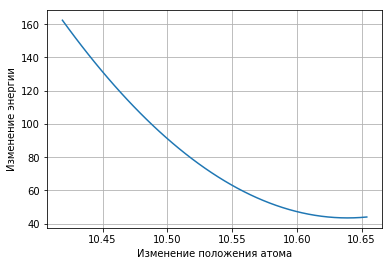


orig atom:  -0.89  observing point:  -0.91 
	energy:  44.48801483943335
orig atom:  -0.89  observing point:  -0.89 
	energy:  43.49823275831288
orig atom:  -0.89  observing point:  -0.87 
	energy:  44.50114743684658
Calculated coefs: 
	a =  2490.8709495818075 
	b =  4434.078605192092 
	c =  2016.8093122148048

Calc Energy:  43.498221939017185  Min_arg:  -0.8900659036423645
Gradients:  -99.30652304679734   0.32831493647518073   99.96315291974679


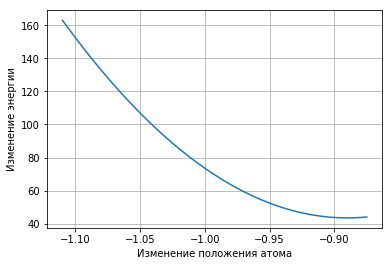


orig atom:  13.04454289654466  observing point:  13.024542896544661 
	energy:  44.45692278332153
orig atom:  13.04454289654466  observing point:  13.04454289654466 
	energy:  43.49823275831288
orig atom:  13.04454289654466  observing point:  13.06454289654466 
	energy:  44.45691532022337
Calculated coefs: 
	a =  2396.7157396968746 
	b =  -62528.12274125569 
	c =  407868.8891170205

Calc Energy:  43.49823023698991  Min_arg:  13.044542935484698
Gradients:  -95.86881624427042   -0.00018665639800019562   95.86844293147442


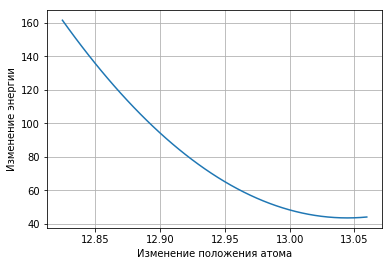

Ort:  x  and num of atom:  250
Prev value:  10.639  new:  10.639143667363728
Possibilities: 
	 eng: [43.4981818930828, 43.498221939017185, 43.49823023698991] 
	 cands: 
		 x:  [44.50670566628312, 43.49823275831288, 44.47813914673526] 
		 y:  [44.48801483943335, 43.49823275831288, 44.50114743684658] 
		 z:  [44.45692278332153, 43.49823275831288, 44.45691532022337]
E_new:  0.0 	E_old:  43.49823275831288 	E_raw:  43.49817015144487 	without DE:  61.9829905023697  DE_elst:  -18.274988794558467 



In [3]:
from output import *
from energy import *
from itertools import cycle

num = 250
l = len(atoms)  # число атомов в изучаемом белке
h = [0.02, 0.02, 0.02]  # размеры шагов по ортам в ангстремах
# L = 3  # сколько шагов делаем вдоль каждого орта с учетом знака
S = 0
r = 10  # размер окрестности атома, по которой честно суммируем

nghb_d = nghb_dihedrals(dihedrals, num)
nghb_a = nghb_angles(angles, num)
nghb_b = nghb_bonds(bonds, num)
nghb_nb = nghbnb(atoms, num, r)[0]
nghbc = nghbnb(atoms, num, r)[1]
[Cx, Cy, Cz] = coef_nb(atoms, num, nghbc)
DE_elst = E_elst(atoms, neighbours, two_bonds_neigh, three_bonds_neigh, num) - \
	  E_elst_m(atoms, neighbours, two_bonds_neigh, three_bonds_neigh, num, nghb_nb)    
E_old = E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh,
		  three_bonds_neigh, num, nghb_d, nghb_a, nghb_b, nghb_nb, full=True)
E_record = E_old

candidates = np.array([0.0, 0.0, 0.0], dtype=np.float64)
actual = np.array([0.0, 0.0, 0.0], dtype=np.float64)
parabola_arg = np.array([0.0, 0.0, 0.0], dtype=np.float64)

coefs = [Cx, Cy, Cz]
coors = [1, 2, 3]

possibilities = [[0, 0, 0], [0, 0, 0]]
cands = [[], [], []]

for ort in range(3):
	c = coefs[ort]
	which_coor = coors[ort]

	prev = atoms[num][which_coor]

	print()
	for indent in [-1, 0, 1]:
		parabola_arg[1 + indent] = np.float64(prev + indent * h[ort])
		atoms[num][which_coor] = prev + indent * h[ort]
		actual[1 + indent] = E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh,
								   three_bonds_neigh, num, nghb_d, nghb_a, nghb_b, nghb_nb, full=True)
		print("orig atom: ", prev, " observing point: ", atoms[num][which_coor], \
			  "\n\tenergy: ", actual[1 + indent]) # , " DE_elst: ", DE_elst, " C: ", c)

	atoms[num][which_coor] = prev
	cands[ort] = [actual[0], actual[1], actual[2]]
	ret = suppose_parabola(parabola_arg, actual)
	print("\nCalc Energy: ", ret.E, " Min_arg: ", ret.arg)
	print("Gradients: ", ret.grad_0, " ", ret.grad_1, " ", ret.grad_2)

	st = 0.005
	mmm = []
	ccc = []
	for i in np.arange(- h[ort] - 0.2, h[ort], st):
		atoms[num][which_coor] = prev  + i # - h[ort] + st
		EE = E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh, num, nghb_d, nghb_a, nghb_b, nghb_nb, full = True) #E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh,nm)
		mmm.append(EE)
		ccc.append(prev + i)
	import matplotlib.pyplot as plt
	plt.plot(ccc,mmm)
	plt.ylabel(r"Изменение энергии")
	plt.xlabel(r"Изменение положения атома")
	plt.grid(True)
	plt.show()
	
	if ((ret.grad_0 >= 0) and (ret.grad_1 >= 0) and (ret.grad_2 >= 0)) \
	         or ((ret.grad_0 < 0) and (ret.grad_1 < 0) and (ret.grad_2 < 0)):
		prev = atoms[num][which_coor]
		print("Recount!!!. Gradients: ", ret.grad_0, " ", ret.grad_1, " ", ret.grad_2)
		
		sign = 0
		if ret.grad_0 < 0:
			sign = -1
			change_point = np.argmin([ret.grad_0, ret.grad_1, ret.grad_2])
		else:
			sign = +1
			change_point = np.argmax([ret.grad_0, ret.grad_1, ret.grad_2])
		parabola_arg[change_point] = ret.arg + 0.01 * sign 
		atoms[num][which_coor] = parabola_arg[change_point]
		actual[change_point] = E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh,
								   three_bonds_neigh, num, nghb_d, nghb_a, nghb_b, nghb_nb, full=True)
		ret = suppose_parabola(parabola_arg, actual)
		
		print("\nCalc Energy: ", ret.E, " Min_arg: ", ret.arg)
		print("Gradients: ", ret.grad_0, " ", ret.grad_1, " ", ret.grad_2)
		possibilities[0][ort] = ret.E
		possibilities[1][ort] = ret.arg
	else:
		possibilities[0][ort] = ret.E
		possibilities[1][ort] = ret.arg
	atoms[num][which_coor] = prev

where = int(np.argmin(possibilities[0]))
E_new = possibilities[0][where]
parabola_min_arg = possibilities[1][where]
# print("E_new: ", E_new, " E_old: ", E_old)
# print("Suppose minimum: ", E_new)
ind = int(np.argmin(candidates))
E_cand = candidates[ind]

energies = np.array([E_new, E_cand, E_old])
minimum_eng = np.argmin(energies)
E_new = energies[minimum_eng]
# if minimum_eng == 2:
# 	# print("Parabola is not at minimum.")
# 	parabola_min_arg = 0
# elif minimum_eng == 1:
# 	# print("Parabola is not at minimum.")
# 	parabola_min_arg = parabola_arg[ind]
# else:
orta = '\'\''
if where == 0:
	orta = 'x'
elif where == 1:
	orta = 'y'
elif where == 2:
	orta = 'z'
print("Ort: ", orta, " and num of atom: ", num)
print("Prev value: ", atoms[num][coors[where]], " new: ", parabola_min_arg)
print("Possibilities: \n\t eng:", possibilities[0], \
	  "\n\t cands: \n\t\t x: ", cands[0], "\n\t\t y: ", cands[1], "\n\t\t z: ", cands[2])
tmp = atoms[num][coors[where]]
atoms[num][coors[where]] = parabola_min_arg
raw_E = E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh,
		   three_bonds_neigh, num, nghb_d, nghb_a, nghb_b, nghb_nb, full=True)
E_small = E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh,
		   three_bonds_neigh, num, nghb_d, nghb_a, nghb_b, nghb_nb, full=False)
print("E_new: ", E_new, "\tE_old: ", E_old, "\tE_raw: ", raw_E, "\twithout DE: ", E_small, " DE_elst: ", DE_elst, "\n")
# print("Parabola works.!!")
atoms[num][coors[where]] = parabola_min_arg


	# "-0.2" чтобы не учитвать погрешности в аппроксимации
if np.float64((E_record - E_new)/ E_record) < 0.05:
	E_record = E_new